## Project 4: Exploring the UK's milk imports and exports

A country's economy depends, sometimes heavily, on its exports and imports. The United Nations Comtrade database provides data on global trade. It will be used to analyse the UK's imports and exports of milk and cream in 2015:

- How much does the UK export and import and is the balance positive (more exports than imports)?
- Which are the main trading partners, i.e. from/to which countries does the UK import/export the most?
- Which are the regular customers, i.e. which countries buy milk from the UK every month?
- Which countries does the UK both import from and export to?

In [ ]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

from pandas import *
%matplotlib inline

## Getting and preparing the data

The data is obtained from the [United Nations Comtrade](http://comtrade.un.org/data/) website, by selecting the following configuration:

- Type of Product: goods
- Frequency: monthly
- Periods: January to May of 2015
- Reporter: United Kingdom
- Partners: all
- Flows: imports and exports
- HS (as reported) commodity codes: 0401 (Milk and cream, neither concentrated nor sweetened) and 0402 (Milk and cream, concentrated or sweetened)

Clicking on 'Preview' results in a message that the data exceeds 500 rows. Data was downloaded using the *Download CSV* button and the download file renamed appropriately.

In [ ]:
LOCATION = '/content/comtrade_milk_uk_jan_jul_15.csv'

The data can also be downloaded directly from Comtrade using the "View API Call" URL, modified in two ways:

- `max=500` is increased to `max=5000` to make sure all data is loaded,
- `&fmt=csv` is added at the end to obtain the data in CSV format.

In [ ]:
# LOCATION = 'http://comtrade.un.org/api/get?max=5000&type=C&freq=M&px=HS&ps=201505%2C201504%2C201503%2C201502%2C201501&r=826&p=all&rg=1%2C2&cc=0401%2C0402&fmt=csv'

On reading in the data, the commodity code has to be read as a string, to not lose the leading zero.

In [ ]:
milk = read_csv(LOCATION, dtype={'Commodity Code':str})
milk.tail(2)

,Classification,Year,Period,Period Desc.,Aggregate Level,Is Leaf Code,Trade Flow Code,Trade Flow,Reporter Code,Reporter,...,Qty,Alt Qty Unit Code,Alt Qty Unit,Alt Qty,Netweight (kg),Gross weight (kg),Trade Value (US$),CIF Trade Value (US$),FOB Trade Value (US$),Flag
635,HS,2015,201505,May 2015,4,0,2,Exports,826,United Kingdom,...,NaN,NaN,NaN,NaN,2213,NaN,37883,NaN,NaN,0
636,HS,2015,201505,May 2015,4,0,2,Exports,826,United Kingdom,...,NaN,NaN,NaN,NaN,1588,NaN,5676,NaN,NaN,0


The data only covers the first five months of 2015. Most columns are irrelevant for this analysis, or contain always the same value, like the year and reporter columns. The commodity code is transformed into a short but descriptive text and only the relevant columns are selected.

In [ ]:
def milkType(code):
    if code == '0401': # neither concentrated nor sweetened
        return 'unprocessed'
    if code == '0402': # concentrated or sweetened
        return 'processed'
    return 'unknown'

COMMODITY = 'Milk and cream'
milk[COMMODITY] = milk['Commodity Code'].apply(milkType)
MONTH = 'Period'
PARTNER = 'Partner'
FLOW = 'Trade Flow'
VALUE = 'Trade Value (US$)'
headings = [MONTH, PARTNER, FLOW, COMMODITY, VALUE]
milk = milk[headings]
milk.head()

,Period,Partner,Trade Flow,Milk and cream,Trade Value (US$)
0,201501,World,Imports,unprocessed,14104602
1,201501,World,Exports,unprocessed,26259792
2,201501,Australia,Exports,unprocessed,50331
3,201501,Austria,Exports,unprocessed,360
4,201501,Belgium,Imports,unprocessed,1424271


The data contains the total imports and exports per month, under the 'World' partner. Those rows are removed to keep only the per-country data.

In [ ]:
milk = milk[milk[PARTNER] != 'World']
milk.head()

,Period,Partner,Trade Flow,Milk and cream,Trade Value (US$)
2,201501,Australia,Exports,unprocessed,50331
3,201501,Austria,Exports,unprocessed,360
4,201501,Belgium,Imports,unprocessed,1424271
5,201501,Belgium,Exports,unprocessed,996031
6,201501,Bulgaria,Exports,unprocessed,191


## Total trade flow

To answer the first question, 'how much does the UK export and import and is the balance positive (more exports than imports)?',
the dataframe is split into two groups: exports from the UK and imports into the UK. The  trade values within each group are summed up to get the total trading.

In [ ]:
grouped = milk.groupby([FLOW])
grouped[VALUE].aggregate(sum)

,Trade Value (US$)
Trade Flow,
Exports,265029661
Imports,156483978


This shows a trade surplus of over 100 million dollars.

## Main trade partners

To address the second question, 'Which are the main trading partners, i.e. from/to which countries does the UK import/export the most?', the dataframe is split by country instead, and then each group aggregated for the total trade value. This is done separately for imports and exports. The result is sorted in descending order so that the main partners are at the top.

In [ ]:
imports = milk[milk[FLOW] == 'Imports']
grouped = imports.groupby([PARTNER])
print('The UK imports from', len(grouped), 'countries.')
print('The 5 biggest exporters to the UK are:')
totalImports = grouped[VALUE].aggregate(sum).sort_values(inplace=False,ascending=False)
totalImports.head()

The UK imports from 21 countries.
The 5 biggest exporters to the UK are:


,Trade Value (US$)
Partner,
Ireland,46263897
France,28314091
Germany,21899123
Netherlands,17658912
Belgium,14325697


The export values can be plotted as a bar chart, making differences between countries easier to see.

<Axes: ylabel='Partner'>

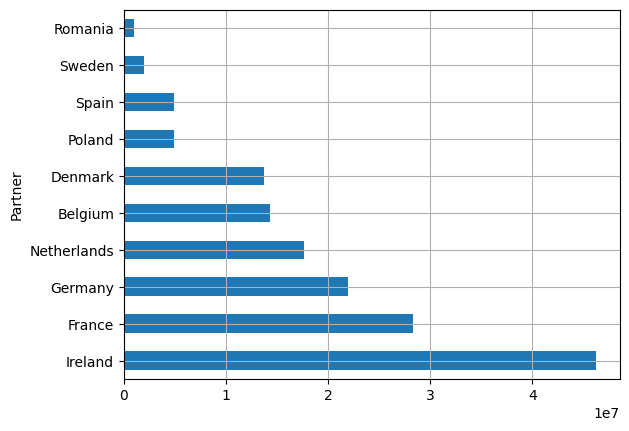

In [ ]:
totalImports.head(10).plot(kind='barh')

In [ ]:
exports = milk[milk[FLOW] == 'Exports']
grouped = exports.groupby([PARTNER])
print('The UK exports to', len(grouped), 'countries.')
print('The 5 biggest importers from the UK are:')
grouped[VALUE].aggregate(sum).sort_values(ascending=False,inplace=False).head()

The UK exports to 107 countries.
The 5 biggest importers from the UK are:


,Trade Value (US$)
Partner,
Ireland,128155891
Netherlands,18018603
China,14111163
Germany,10828464
"China, Hong Kong SAR",9482458


## Regular importers

Given that there are two commodities, the third question, 'Which are the regular customers, i.e. which countries buy milk from the UK every month?', is meant in the sense that a regular customer imports both commodities every month. This means that if the exports dataframe is grouped by country, each group has exactly ten rows (two commodities bought each of the five months). To see the countries, only the first month of one commodity has to be listed, as by definition it's the same countries every month and for the other commodity.

In [ ]:
def buysEveryMonth(group):
    return len(group) == 10

grouped = exports.groupby([PARTNER])
regular = grouped.filter(buysEveryMonth)
regular[(regular[MONTH] == 201501) & (regular[COMMODITY] == 'processed')]

,Period,Partner,Trade Flow,Milk and cream,Trade Value (US$)
268,201501,Belgium,Exports,processed,142610
271,201501,China,Exports,processed,1013141
275,201501,Cyprus,Exports,processed,6625
280,201501,Denmark,Exports,processed,107883
284,201501,France,Exports,processed,178262
287,201501,Germany,Exports,processed,2588380
292,201501,"China, Hong Kong SAR",Exports,processed,1110086
294,201501,Hungary,Exports,processed,2119
298,201501,Ireland,Exports,processed,4020981
300,201501,Italy,Exports,processed,23267


Just over 75% of the total UK exports are due to these regular customers.

In [ ]:
regular[VALUE].sum() / exports[VALUE].sum()

np.float64(0.7583526396315317)

## Bi-directional trade

To address the fourth question,
'Which countries does the UK both import from and export to?', a pivot table is used to list the total export and import value for each country.

In [ ]:
countries = pivot_table(milk, index=[PARTNER], columns=[FLOW],
                        values=VALUE, aggfunc=sum)
countries.head()

Trade Flow,Exports,Imports
Partner,,
Algeria,8087885.0,NaN
Angola,2416129.0,NaN
Antigua and Barbuda,22218.0,NaN
"Areas, nes",51205.0,NaN
Australia,81644.0,NaN


Removing the rows with a missing value will result in only those countries with bi-directional trade flow with the UK.

In [ ]:
countries.dropna()

Trade Flow,Exports,Imports
Partner,,
Austria,56279.0,780.0
Belgium,7209121.0,14325697.0
Czech Rep.,2590.0,486889.0
Denmark,335068.0,13681759.0
France,9381762.0,28314091.0
Germany,10828464.0,21899123.0
Hungary,71378.0,4762.0
Ireland,128155891.0,46263897.0
Italy,173689.0,321635.0


## Provide Notebook-1 Tasks Solutions below (Execute them)

In [ ]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

import matplotlib
matplotlib.rcParams['axes.grid'] = True # show gridlines by default
%matplotlib inline

import pandas as pd

In [ ]:
LOCATION='comtrade_cereal_uk_monthly_23.csv'

In [ ]:
load_test=read_csv('comtrade_cereal_uk_monthly_23.csv', dtype={'Commodity Code':str}, encoding = "ISO-8859-1")

In [ ]:
cereal = pd.read_csv(LOCATION, dtype={'Commodity Code':str, 'Reporter Code':str}, encoding = "ISO-8859-1")
cereal.head(3)

,typeCode,freqCode,refPeriodId,refYear,refMonth,period,reporterCode,reporterISO,reporterDesc,flowCode,...,netWgt,isNetWgtEstimated,grossWgt,isGrossWgtEstimated,cifvalue,fobvalue,primaryValue,legacyEstimationFlag,isReported,isAggregate
C,A,20230101,2023,52,2023,826,GBR,United Kingdom,M,Import,...,False,0,False,15264.644,NaN,15264.644,0,False,True,NaN
C,A,20230101,2023,52,2023,826,GBR,United Kingdom,M,Import,...,False,0,False,4194.949,NaN,4194.949,0,False,True,NaN
C,A,20230101,2023,52,2023,826,GBR,United Kingdom,M,Import,...,False,0,False,3605.792,NaN,3605.792,0,False,True,NaN


In [ ]:
COLUMNS = ['refYear', 'refPeriodId','flowCode','reporterISO', 'partnerDesc', 'cmdDesc','cmdCode','primaryValue']
cereal = cereal[COLUMNS]

In [ ]:
cereal_world = cereal[cereal['partnerDesc'] == 'World']
cereal_countries = cereal[cereal['partnerDesc'] != 'World']

In [ ]:
cereal_countries.to_csv('countrycereal.csv', index=False)

In [ ]:
load_test = pd.read_csv('countrycereal.csv', dtype={'Commodity Code':str, 'Reporter Code':str})
load_test.head(5)

,refYear,refPeriodId,flowCode,reporterISO,partnerDesc,cmdDesc,cmdCode,primaryValue
0,52,2023,Import,United Kingdom,0,6,"Cereals; wheat and meslin, durum wheat, seed",0
1,52,2023,Import,United Kingdom,0,6,"Cereals; wheat and meslin, durum wheat, seed",0
2,52,2023,Import,United Kingdom,0,6,"Cereals; wheat and meslin, durum wheat, seed",0
3,52,2023,Import,United Kingdom,0,6,"Cereals; wheat and meslin, durum wheat, seed",0
4,52,2023,Import,United Kingdom,0,6,"Cereals; wheat and meslin, durum wheat, seed",0


In [ ]:
print("Flow codes in dataset:", cereal['flowCode'].unique())

Flow codes in dataset: ['Import' 'Export']


In [ ]:
cereal_imports = cereal[cereal['flowCode'] == 'Import']
cereal_countries_imports = cereal_countries[cereal_countries['flowCode'] == 'Import']
cereal_world_imports=cereal_world[cereal_world['flowCode'] == 'Import']

In [ ]:
cerealImportsInJanuary2023 = cereal_countries_imports[cereal_countries_imports['refPeriodId'] == 2023]
display(cerealImportsInJanuary2023.sort_values('primaryValue', ascending=False).head(10))

,refYear,refPeriodId,flowCode,reporterISO,partnerDesc,cmdDesc,cmdCode,primaryValue
C,52,2023,Import,United Kingdom,0,0,All Commodities,4
C,52,2023,Import,United Kingdom,0,0,All Commodities,4
C,52,2023,Import,United Kingdom,0,0,All Commodities,4
C,52,2023,Import,United Kingdom,0,0,All Commodities,4
C,52,2023,Import,United Kingdom,0,0,All Commodities,4
C,52,2023,Import,United Kingdom,0,0,All Commodities,4
C,52,2023,Import,United Kingdom,0,0,All Commodities,4
C,52,2023,Import,United Kingdom,0,0,All Commodities,4
C,52,2023,Import,United Kingdom,0,0,All Commodities,4
C,52,2023,Import,United Kingdom,0,0,All Commodities,4


In [ ]:
cereal_exports = cereal[cereal['flowCode'] == 'Export']
cereal_countries_exports = cereal_countries[cereal_countries['flowCode'] == 'Export']
cereal_world_exports=cereal_world[cereal_world['flowCode'] == 'Export']
cerealExportsInJanuary2023 = cereal_countries_exports[cereal_countries_exports['refPeriodId'] == 2023]
display(cerealExportsInJanuary2023.sort_values('primaryValue', ascending=False).head(10))

,refYear,refPeriodId,flowCode,reporterISO,partnerDesc,cmdDesc,cmdCode,primaryValue
C,52,2023,Export,United Kingdom,0,6,"Cereals; wheat and meslin, durum wheat, other ...",6
C,52,2023,Export,United Kingdom,0,0,All Commodities,4
C,52,2023,Export,United Kingdom,0,0,All Commodities,4
C,52,2023,Export,United Kingdom,0,0,All Commodities,4
C,52,2023,Export,United Kingdom,0,0,All Commodities,4
C,52,2023,Export,United Kingdom,0,0,All Commodities,4
C,52,2023,Export,United Kingdom,0,0,All Commodities,4
C,52,2023,Export,United Kingdom,0,0,All Commodities,4
C,52,2023,Export,United Kingdom,0,0,All Commodities,4
C,52,2023,Export,United Kingdom,0,0,All Commodities,4


Based on the inspection, please adjust the filtering conditions. Here's how you might correct your code, assuming `flowCode` is 'Import' and you want to filter for a `refPeriodId` that exists in your data, for example, 20230101 (January 2023) and that '0' in `partnerDesc` represents a specific partner or 'World'. If '0' represents 'World', you would filter it out for country-specific data. If it represents an actual country, you might want to keep it.

**Note**: You'll need to confirm what '0' in `partnerDesc` signifies in your dataset.

## Provide Notebook-2 Tasks Solutions below (Execute them)

In [ ]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

import matplotlib
matplotlib.rcParams['axes.grid'] = True # show gridlines by default
%matplotlib inline

import pandas as pd

In [ ]:
if pd.__version__.startswith('0.23'):
    # this solves an incompatibility between pandas 0.23 and datareader 0.6
    # taken from https://stackoverflow.com/questions/50394873/
    core.common.is_list_like = api.types.is_list_like

from pandas_datareader.wb import download

In [ ]:
?download

In [ ]:
groups = cereal_countries.groupby('flowCode')

In [ ]:
GROUPING_COMMFLOW = ['cmdCode','flowCode']

groups = cereal_countries.groupby(GROUPING_COMMFLOW)
groups.groups.keys()

dict_keys([('All Commodities', 'Export'), ('All Commodities', 'Import'), ('Cereals; wheat and meslin, durum wheat, other than seed', 'Export'), ('Cereals; wheat and meslin, durum wheat, other than seed', 'Import'), ('Cereals; wheat and meslin, durum wheat, seed', 'Export'), ('Cereals; wheat and meslin, durum wheat, seed', 'Import')])

In [ ]:
france_import = cereal_countries[
    (cereal_countries['partnerDesc'] == 'France') &
    (cereal_countries['flowCode'] == 'Import')
]
france_imports

,refYear,refPeriodId,flowCode,reporterISO,partnerDesc,cmdDesc,cmdCode,primaryValue


In [ ]:
load_test = pd.read_csv('countrycereal.csv', dtype={'Commodity Code':str, 'Reporter Code':str})
load_test.head(2)

,refYear,refPeriodId,flowCode,reporterISO,partnerDesc,cmdDesc,cmdCode,primaryValue
0,52,2023,Import,United Kingdom,0,6,"Cereals; wheat and meslin, durum wheat, seed",0
1,52,2023,Import,United Kingdom,0,6,"Cereals; wheat and meslin, durum wheat, seed",0


In [ ]:
groups = cereal_countries.groupby(['cmdCode'])
groups.get_group('Cereals; wheat and meslin, durum wheat, seed').sort_values('primaryValue', ascending=False).head()

,refYear,refPeriodId,flowCode,reporterISO,partnerDesc,cmdDesc,cmdCode,primaryValue
C,52,2023,Import,United Kingdom,0,6,"Cereals; wheat and meslin, durum wheat, seed",0
C,52,2023,Import,United Kingdom,0,6,"Cereals; wheat and meslin, durum wheat, seed",0
C,52,2023,Import,United Kingdom,0,6,"Cereals; wheat and meslin, durum wheat, seed",0
C,52,2023,Import,United Kingdom,0,6,"Cereals; wheat and meslin, durum wheat, seed",0
C,52,2023,Import,United Kingdom,0,6,"Cereals; wheat and meslin, durum wheat, seed",0


## Provide Notebook-3 Tasks Solutions below (Execute them)

In [ ]:
As you complete the tasks, think about these questions:

For your particular dataset, how did you group the data and what questions did you ask of it?

Which countries were the major partners of your reporter country for the different groupings?

With the ability to group data so easily, what other sorts of questions would you like to be able to ask?

## Provide Notebook-4 Tasks Solutions below (Execute them)

In [ ]:
cereal_world_imports.groupby('cmdCode')['primaryValue'].aggregate(sum)

,primaryValue
cmdCode,


In [ ]:
cereal_imports_grouped=cereal_countries_imports.groupby('cmdCode')
cereal_imports_grouped['primaryValue'].aggregate(sum)

,primaryValue
cmdCode,
All Commodities,580
"Cereals; wheat and meslin, durum wheat, other than seed",0
"Cereals; wheat and meslin, durum wheat, seed",0


In [ ]:
cereal_countries_imports_totals=cereal_countries_imports.groupby('partnerDesc')[['primaryValue']].aggregate(sum)
cereal_countries_imports_totals.sort_values('primaryValue', ascending=False).head()

,primaryValue
partnerDesc,
0,580


<Axes: ylabel='cmdCode'>

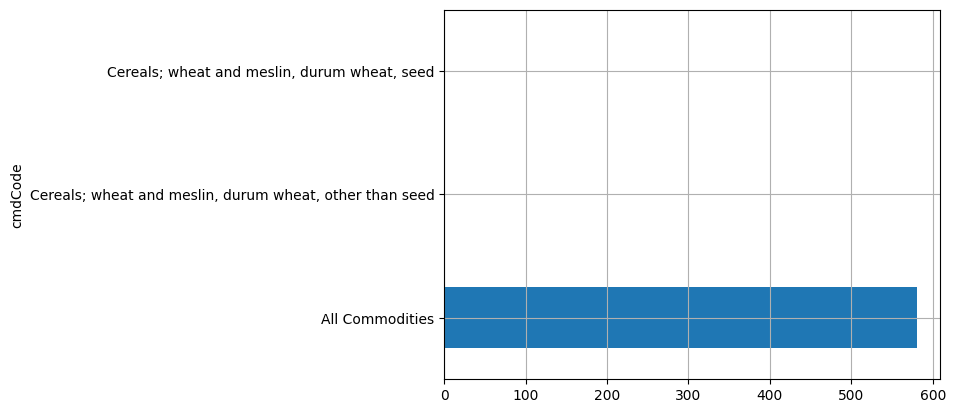

In [ ]:
cereal_imports_grouped['primaryValue'].aggregate(sum).plot(kind='barh')

In [ ]:
monthlies=cereal_countries_imports.groupby(['cmdDesc','primaryValue','refPeriodId'])['primaryValue'].aggregate(sum)
monthlies

cmdDesc  primaryValue  refPeriodId
0        0             2023             0
         4             2023           580
6        0             2023             0
Name: primaryValue, dtype: int64

In [ ]:
from numpy import mean

GROUPING_COMMFLOWPERIOD=['cmdDesc','flowCode','refPeriodId']
cereal_countries.groupby(GROUPING_COMMFLOWPERIOD)['primaryValue'].aggregate([sum, min, max, mean])

sum  min  max      mean
cmdDesc flowCode refPeriodId                         
0       Export   2023         836    0    4  3.572650
        Import   2023         580    0    4  2.478632
6       Export   2023           6    0    6  0.285714
        Import   2023           0    0    0  0.000000

<Axes: ylabel='cmdCode,refPeriodId'>

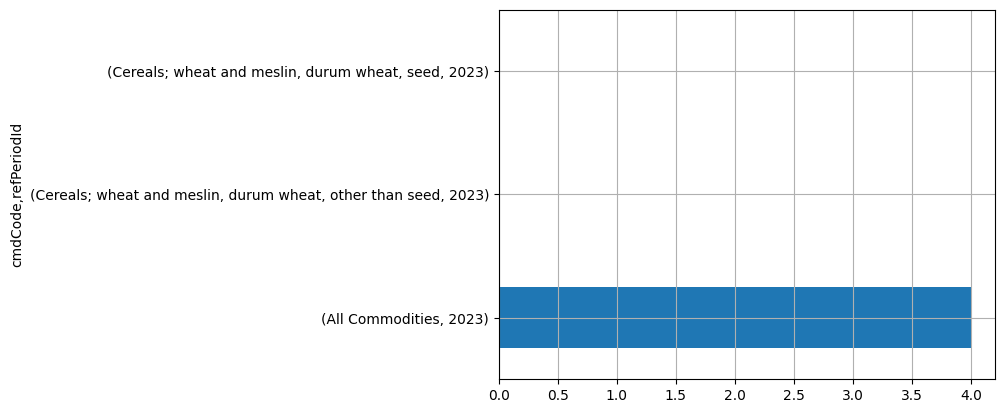

In [ ]:
cereal_countries_imports.groupby(['cmdCode','refPeriodId'])['primaryValue'].aggregate(max).plot(kind='barh')

In [ ]:
cereal_bypartner_total=cereal[cereal["flowCode"]=='Imports'].groupby(['partnerDesc'])['primaryValue'].aggregate(sum)
cereal_bypartner_total.head(5)

,primaryValue
partnerDesc,


## Conclusions

The milk and cream trade of the UK from January to May 2015 was analysed in terms of which countries the UK mostly depends on for income (exports) and goods (imports). Over the period, the UK had a trade surplus of over 100 million US dollars.

Ireland is the main partner, but it imported from the UK almost the triple in value than it exported to the UK.

The UK exported to over 100 countries during the period, but only imported from 21 countries, the main ones (top five by trade value) being geographically close. China and Hong Kong are the main importers that are not also main exporters.

The UK is heavily dependent on its regular customers, the 16 countries that buy all types of milk and cream every month. They contribute three quarters of the total export value.

The UK has bi-directional trade (i.e. both exports and imports) with 20 countries, although for some the trade value (in US dollars) is suspiciously low, which raises questions about the data's accuracy.


## Now repeat the analysis with your own data gotten from Comtrade website

In [ ]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

from pandas import *
%matplotlib inline

In [ ]:
LOCATION = 'comtrade_cereal_uk_monthly_23'

In [ ]:
cereal = pd.read_csv(LOCATION, dtype={'Commodity Code':str, 'Reporter Code':str}, encoding = "ISO-8859-1")
cereal.head(3)

,typeCode,freqCode,refPeriodId,refYear,refMonth,period,reporterCode,reporterISO,reporterDesc,flowCode,...,netWgt,isNetWgtEstimated,grossWgt,isGrossWgtEstimated,cifvalue,fobvalue,primaryValue,legacyEstimationFlag,isReported,isAggregate
C,A,20230101,2023,52,2023,826,GBR,United Kingdom,M,Import,...,False,0,False,15264.644,NaN,15264.644,0,False,True,NaN
C,A,20230101,2023,52,2023,826,GBR,United Kingdom,M,Import,...,False,0,False,4194.949,NaN,4194.949,0,False,True,NaN
C,A,20230101,2023,52,2023,826,GBR,United Kingdom,M,Import,...,False,0,False,3605.792,NaN,3605.792,0,False,True,NaN


In [ ]:
def cerealType(code):
    if code == '100111':
        return 'Cereals; wheat and meslin, durum wheat, seed'
    if code == '100119':
        return 'Cereals; wheat and meslin, durum wheat, other than seed'
    return 'unknown'

COMMODITY = 'Cereals'
cereal[COMMODITY] = cereal['cmdCode'].apply(cerealType)
MONTH = 'refPeriodId'
PARTNER = 'partnerDesc'
FLOW = 'flowCode'
VALUE = 'primaryValue'
headings = [MONTH, PARTNER, FLOW, COMMODITY, VALUE]
cereal = cereal[headings]
cereal.head()

,refPeriodId,partnerDesc,flowCode,Cereals,primaryValue
C,2023,0,Import,unknown,0
C,2023,0,Import,unknown,0
C,2023,0,Import,unknown,0
C,2023,0,Import,unknown,0
C,2023,0,Import,unknown,0


In [ ]:
cereal = cereal[cereal[PARTNER] != 'World']
cereal.head()

,refPeriodId,partnerDesc,flowCode,Cereals,primaryValue
C,2023,0,Import,unknown,0
C,2023,0,Import,unknown,0
C,2023,0,Import,unknown,0
C,2023,0,Import,unknown,0
C,2023,0,Import,unknown,0


In [ ]:
imports = cereal[cereal[FLOW] == 'Import']
grouped = imports.groupby([PARTNER])
print('The UK imports from', len(grouped), 'countries.')
print('The 5 biggest exporters to the UK are:')
totalImports = grouped[VALUE].aggregate(sum).sort_values(inplace=False,ascending=False)
totalImports.head()

The UK imports from 1 countries.
The 5 biggest exporters to the UK are:


,primaryValue
partnerDesc,
0,580


<Axes: ylabel='partnerDesc'>

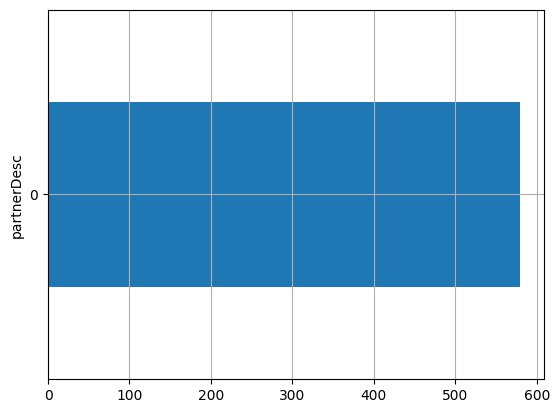

In [ ]:
totalImports.head(10).plot(kind='barh')

In [ ]:
exports = cereal[cereal[FLOW] == 'Export']
grouped = exports.groupby([PARTNER])
print('The UK exports to', len(grouped), 'countries.')
print('The 5 biggest importers from the UK are:')
grouped[VALUE].aggregate(sum).sort_values(ascending=False,inplace=False).head()

The UK exports to 1 countries.
The 5 biggest importers from the UK are:


,primaryValue
partnerDesc,
0,842


In [ ]:
def buysEveryMonth(group):
    return len(group) == 10

grouped = exports.groupby([PARTNER])
regular = grouped.filter(buysEveryMonth)
regular[(regular[MONTH] == 202301) & (regular[COMMODITY] == 'Cereals; wheat and meslin, durum wheat, seed')]

,refPeriodId,partnerDesc,flowCode,Cereals,primaryValue


In [ ]:
regular[VALUE].sum() / exports[VALUE].sum()

np.float64(0.0)

In [ ]:
countries = pivot_table(cereal, index=[PARTNER], columns=[FLOW],
                        values=VALUE, aggfunc=sum)
countries.head()

flowCode,Export,Import
partnerDesc,,
0,842,580


**Exploring the UK’s cereal imports and exports**

Exploring the UK’s cereal imports and exports offers valuable insight into the country’s economic relationships and its position within global food supply chains. Using data from the United Nations Comtrade database, this analysis focuses on the flows of cereals into and out of the UK in 2023. Understanding how much the UK imports relative to how much it exports reveals whether the nation operates at a trade surplus or deficit in cereals, providing a window into its level of reliance on foreign producers. Equally important is identifying the UK’s principal trading partners, which are countries that supply the bulk of imported cereals and those that consistently purchase UK cereal exports. These relationships highlight both economic interdependence and strategic trade patterns. By examining monthly data, it becomes possible to see which nations serve as regular, reliable partners, appearing repeatedly in the UK’s trade records throughout the year. Finally, analysing countries that both import from and export to the UK uncovers two-way trading relationships that reflect deeper commercial ties and mutual market dependence. Together, these perspectives create a comprehensive picture of the UK’s cereal trade dynamics and its interconnectedness with global agricultural markets.

**Getting and preparing the data**

The data is obtained from the United Nations Comtrade website, by selecting the following configuration:

Type of Product: goods
Frequency: monthly
Periods: January 2023
Reporter: United Kingdom
Partners: all
Flows: imports and exports
HS (as reported) commodity codes: 100111 (Cereals; wheat and meslin, durum wheat, seed) and 100119 (Cereals; wheat and meslin, durum wheat, other than seed)

Link to publication: https://datababe.hashnode.dev/week-9-at-dataraflow-what-can-trade-data-really-tell-us-about-a-country